In [2]:
%matplotlib widget


import sys
sys.path.append('src/')

import numpy as np
import matplotlib.pyplot as plt
import coordinates as coord
import kepler as kpl
from scipy.integrate import odeint # this is new!
# from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs           # projection definitions
import cartopy.feature as cfeature   # optional land / ocean features

In [4]:
x, y, z, vx, vy, vz = kpl.elem2coord(350, 0, 30 * np.pi/180, 0, 0, 0, 0, 0, 7.2)  # km^3/s^2
print('x, y, z, vx, vy, vz =', x, y, z, vx, vy, vz)

x, y, z, vx, vy, vz = 350.0 0.0 0.0 0.0 0.12421180068162377 0.0717137165600636


## Useful Constants

In [2]:
pi      = np.pi
deg2rad = pi / 180.0
rad2deg = 180.0 / pi

min2rad = deg2rad / 60.0
rad2min = rad2deg * 60.0

sec2rad = min2rad / 60.0
rad2sec = rad2min * 60.0

day2sec = 86400.0

AU2meter = 1.496e11 

G = 6.6743e-11
m_sun = 1.989e30
m_E = 5.97219e24

r_E = 6378e3 # m


## Functions for converting true, eccentric and mean anomalies

In [3]:
def E2nu(E, e):
    nu = np.sqrt((1 + e) / (1 - e)) 
    nu = 2 * np.arctan(nu * np.tan(E / 2))
    return nu

def nu2E(nu, e):
    cosnu = np.cos(nu)
    sinnu = np.sin(nu)
    sinE  = np.sqrt(1 - e * e) * sinnu / (1 + e * cosnu)
    cosE = (cosnu + e) / (1 + e * cosnu)
    E = v + np.arctan((sinE * cosnu - cosE * sinnu) / (cosE * cosnu + sinE * sinnu))

def E2M(E, e):
    return E - e * np.sin(E)

def M2E(M, e, E0):
    d   = np.array([1.0])
    eps = 1.0e-12
    E   = E0
    i   = 0
    while (d > eps).any():
        E_new = E - (E - e * np.sin(E) - M) / (1.0 - e * np.cos(E))
        d = np.abs(E_new - E)
        E = E_new
        i = i + 1
    return E, i

def nu2M(nu,e):
    E = nu2E(nu, e) # first, we compute the eccentric anomaly
    return E2M(E, e)

def M2nu(M,e):
    E, _ = M2E(M, e, M) # first, we compute the eccentric anomaly
    return E2nu(E, e)

## Q2 Orbital speed and orbital transfers

### 2a)

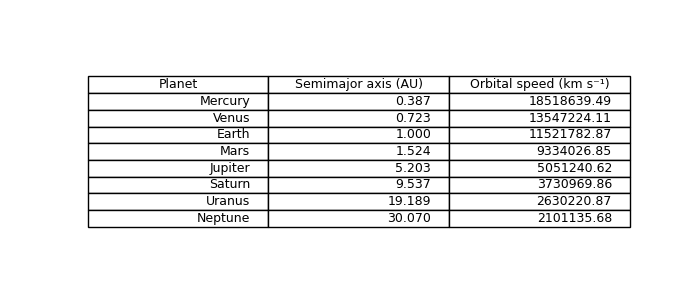

In [4]:
# Planet semimajor axes of heliocentric orbit in order: Mercury, Venus, Mars, Jupiter, Saturn, Uranus, Neptune (AU)
planets = [
    "Mercury", "Venus", "Earth", "Mars",
    "Jupiter", "Saturn", "Uranus", "Neptune"
]
a_planets_AU = np.array([0.38709927, 0.72333566, 1.00000261, 1.52371034, 5.20288700, 9.53667594, 19.18916464, 30.06992276])
a_planets_m = AU2meter * a_planets_AU

mu_sun = G * m_sun
v_orbs = []
v_m_s     = np.sqrt(mu_sun / a_planets_AU)   # m s^-1
v_km_s    = v_m_s / 1000.0 # km s^-1

fig, ax = plt.subplots(figsize=(7, 3))
ax.axis("off")
table = ax.table(
    cellText=[
        [p, f"{a:.3f}", f"{v:.2f}"]    # rows: Planet | a(AU) | v(km s^-1)
        for p, a, v in zip(planets, a_planets_AU, v_km_s)
    ],
    colLabels=["Planet", "Semimajor axis (AU)", "Orbital speed (km s⁻¹)"],
    loc="center"
)


### 2c)

In [5]:
# Orbit parameters
h = 400e3 #m
mu_E = G * m_E
r_a = 384400e3
r_p = r_E + h
a = (r_p + r_a)/2

v_LEO = np.sqrt(mu_E / (r_E + h))
v_EM_apogee = np.sqrt(mu_E*(2/r_p - 1/a))

delta_v = v_EM_apogee - v_LEO
print(f"We need a ∆V of: {delta_v} m/s")

We need a ∆V of: 3082.0906434409453 m/s


### 2d)

In [6]:
V_M_circ = np.sqrt(mu_E / r_a)
V_a_EM = np.sqrt(mu_E*(2/r_a - 1/a))

delta_v = V_M_circ - V_a_EM
print(f"∆V needed to circularise near moon orbit: {delta_v} m/s")

∆V needed to circularise near moon orbit: 828.7409449981516 m/s


### 3a Test Case

In [7]:
a = 26600000.0
e = 0.74
i = 63.4 
omega = 270 
Omega  = 45 
M0 = 10 
t = 100
tf = 21700
mu = 3.986004418e14 # (m^3 / s^-2)

x, y, z, vx, vy, vz = kpl.elem2coord(a, e, i, omega, Omega, M0, t, tf, mu)
print(x, y, z, vx, vy, vz)

-18421060.827934176 755215.3295226124 10259216.244456427 -3577.6936705743647 -3022.396356831412 929.7934526624314


### 3b Designing Orbit over Australia

In [8]:
# Molniya - Russia-US friendship orbit
a        = np.cbrt((mu_E * (8.0 * 3600.0)**2) / ( 4*pi**2)) # necessary time to complete one orbit in 8 hours
e        = 0.74
i        = 40.0  * deg2rad # Used latitude of -25° (Australia)
omega    = 270.0 * deg2rad # switched to 90 degrees to make apocenter Southernmost point
Omega    = 150.0 * deg2rad
M0       = 0.0  * deg2rad
t0       = 0.0
t_array  = t0 + np.arange(0, 3*day2sec, 10)

print(a)

20307425.070957948


### Get position and velocity arrays in perifocal frame

In [9]:
n = np.sqrt(mu / (a ** 3))

M = M0 + n * (t_array - t0)

# True Anomaly
nu = M2nu(M, e)

# Specific angular momentum
h_squared =  mu * a * (1 - e ** 2)
h         =  np.sqrt(h_squared)
 
# Position and velocity in the perifocal frame
r_orb     = h_squared / mu / (1 + e * np.cos(nu)) * np.array([np.cos(nu), np.sin(nu), np.zeros(nu.shape)])
v_orb     = mu / h * np.array((-np.sin(nu), e + np.cos(nu), np.zeros(nu.shape)))

# Convert to ECI frame
R_total   = coord.rotation(-Omega, 3) @ coord.rotation(-i, 1) @ coord.rotation(-omega, 3)

r_eci     = R_total @ r_orb
v_eci     = R_total @ v_orb

### Compute array of Greenwich Hour Angles (denoted by S)

In [10]:
d = t_array / 86400.0
S = (280.4606 + 360.9856473 * (d)) * deg2rad
R = [coord.rotation(S[i],3) for i in range(len(S))]

In [11]:
# Rotate from ECI to ECEF
r_ECEF = np.array([np.dot(R[i],r_eci[:,i].T) for i in range(len(S))])

x_ECEF = r_ECEF[:,0]
y_ECEF = r_ECEF[:,1]
z_ECEF = r_ECEF[:,2]

# Get latitude, longitude
(lon, lat, _) = coord.cart2sph(x_ECEF,y_ECEF,z_ECEF)

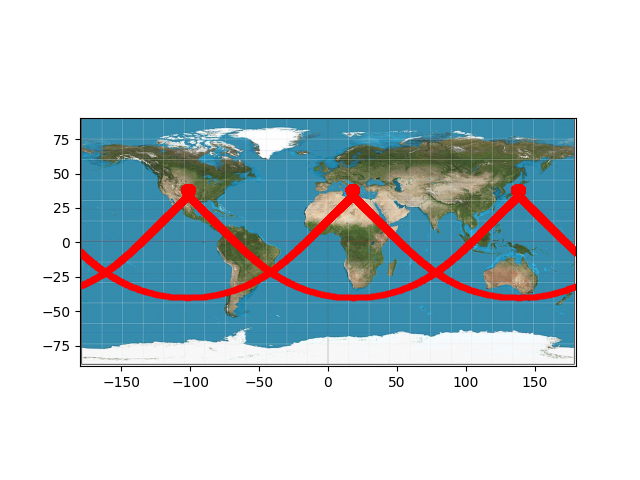

In [12]:
plt.figure()
plt.scatter(np.array(lon)*rad2deg, np.array(lat)*rad2deg, c='red', marker='.')
img = plt.imread("Earth.jpg")
plt.imshow(img, extent=[-180, 180, -90, 90])

### 3c Test Case:

In [13]:
x = -15891749.923216075 
y = 13329971.70114956 
z = 41262812.92841873
vx = -983.4914204373653
vy = -1126.4374128032644
vz = -201.84826266167386
mu = 3.986004418e14 # (m^3 / s^-2)

a, e, i, omega, Omega, M = kpl.coord2elem(x, y, z, vx, vy, vz, mu)
print(a, e, i, omega, Omega, M)

26599999.999999993 0.74 1.106538745764405 4.71238898038469 0.7853981633974482 3.317936799213638


## 4 Orbital track of ISS

### 4a) Computing positions

In [14]:
i_ISS = 51.6344 
Omega_ISS = 119.1760 
e_ISS = 0.0002307 
omega_ISS = 106.2285 
M_ISS = 253.8958 
n = 15.49506546509779 * 2*pi / day2sec # mean motion in rad/s
mu = 3.986004418e14 # (m^3 / s^-2)
days = 133.44462271

a_ISS = np.cbrt(mu / n**2)

t = days * day2sec # convert days to seconds

JD_J2000 = coord.gregorian2JD(1.0,1.5,2000.0) # Julian day at 12 h UTC on 1st of January 2000
JD_J2025 = coord.gregorian2JD(1.0,1.0,2025.0) # Julian day at 0 h UTC on 1st of January 2025
d = JD_J2025 - JD_J2000 + t / day2sec         # where t is the number of seconds within the year of 2025

GHA = 280.46061837 + 360.9856473 * d
GHA = GHA % 360.0  # Normalize to [0, 360) degrees

x, y, z, vx, vy, vz = kpl.elem2coord(a_ISS, e_ISS, i_ISS,
                                     omega_ISS, Omega_ISS, M_ISS, 0, 0, mu)
r_ISS_ECEF = coord.rotation(GHA * deg2rad, 3) @ [x, y, z]

# Check the ECI coordinates before rotation
print(f"ECI position magnitude: {np.sqrt(x**2 + y**2 + z**2)/1000:.2f} km")
print(f"ECEF position magnitude: {np.linalg.norm(r_ISS_ECEF)/1000:.2f} km")

print(f"ISS ECEF coordinates: {r_ISS_ECEF} m")


ECI position magnitude: 6797.62 km
ECEF position magnitude: 6797.62 km
ISS ECEF coordinates: [-1081164.12556005  2794059.84058461  6101802.36274754] m


### Q4b)

### Find Date difference between given ISS TLE time and desired time

In [15]:
# We know the M0 at day = 133.44462271 which is May 13
JD_J2025_0513 = coord.gregorian2JD(5.0, 13.44462271, 2025.0) # Julian day at TLE given date
JD_J2025_0528 = coord.gregorian2JD(5.0, 28 + 19/24, 2025.0) # Julian day at 7PM UTC 28th of May 2025

delta_t = JD_J2025_0528 - JD_J2025_0513 # difference in days


M_0_ISS = (M_ISS + n * (delta_t * day2sec)) % (2*pi)  # M at 28th of May 2025 12PM PDT (UTC-19:00)

print(delta_t) # difference in days
print(f"M at 28th of May 2025 12PM PDT (UTC-19:00): {M_0_ISS} rad")

15.347043956629932
M at 28th of May 2025 12PM PDT (UTC-19:00): 1.3334326905755773 rad


In [16]:
# ISS orbit parameters
a        = a_ISS
e        = e_ISS
i        = i_ISS * deg2rad
omega    = omega_ISS * deg2rad
Omega    = Omega_ISS * deg2rad
M0       = M_0_ISS
t0       = 0.0
t_array  = t0 + np.arange(0, day2sec, 10)
dt       = 60.0*10 # 60 seconds

### Get position and velocity arrays in perifocal frame

In [17]:
n = np.sqrt(mu / (a ** 3))

M = M0 + n * (t_array - t0)

# True Anomaly
nu = M2nu(M, e)

# Specific angular momentum
h_squared =  mu * a * (1 - e ** 2)
h         =  np.sqrt(h_squared)
 
# Position and velocity in the perifocal frame
r_orb     = h_squared / mu / (1 + e * np.cos(nu)) * np.array([np.cos(nu), np.sin(nu), np.zeros(nu.shape)])
v_orb     = mu / h * np.array((-np.sin(nu), e + np.cos(nu), np.zeros(nu.shape)))

# Convert to ECI frame
R_total   = coord.rotation(-Omega, 3) @ coord.rotation(-i, 1) @ coord.rotation(-omega, 3)

r_eci     = R_total @ r_orb
v_eci     = R_total @ v_orb

### Compute array of Greenwich Hour Angles (denoted by S)

In [18]:
d = JD_J2025_0528 - JD_J2000 + t_array / 86400.0
S = (280.4606 + 360.9856473 * (d)) * deg2rad
R = [coord.rotation(S[i],3) for i in range(len(S))]

### Rotate from ECI to ECEF with GHA and get Lat, long.

In [19]:
# Rotate from ECI to ECEF
r_ECEF = np.array([np.dot(R[i],r_eci[:,i].T) for i in range(len(S))])

x_ECEF = r_ECEF[:,0]
y_ECEF = r_ECEF[:,1]
z_ECEF = r_ECEF[:,2]

# Get latitude, longitude
(lon, lat, _) = coord.cart2sph(x_ECEF,y_ECEF,z_ECEF)

### Plot Ground track

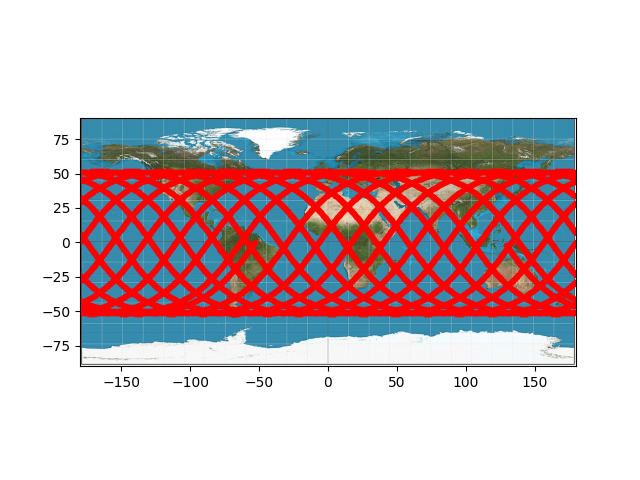

In [20]:
plt.figure()
plt.scatter(np.array(lon)*rad2deg, np.array(lat)*rad2deg, c='red', marker='.')
img = plt.imread("Earth.jpg")
plt.imshow(img, extent=[-180, 180, -90, 90])